## Optimization Final

In [1]:
using JuMP, CSV, DataFrames

### Value Stocks

In [2]:
returns = DataFrame(CSV.File("consump_value_returns.csv",header = true))
cov = DataFrame(CSV.File("consump_value_cov.csv",header = true))

Row,CALM,CASY,COKE,DECK,F,LANC,LOPE,LRN,ULTA,YUMC
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.000413595,-4.87807e-6,4.66453e-5,-3.89746e-6,6.64189e-5,4.96605e-5,-7.87572e-6,1.8309e-5,4.40821e-5,1.11565e-5
2,-4.87807e-6,0.000195346,2.82625e-5,4.07751e-5,2.93e-5,3.8486e-5,2.46056e-5,2.77758e-5,3.28159e-5,1.78396e-5
3,4.66453e-5,2.82625e-5,0.000433946,3.69934e-5,5.17159e-5,2.98851e-5,3.83561e-5,3.39665e-5,2.33298e-5,1.12864e-5
4,-3.89746e-6,4.07751e-5,3.69934e-5,0.000386678,2.12351e-5,1.67902e-5,4.32818e-5,4.00627e-5,6.09835e-5,5.35813e-5
5,6.64189e-5,2.93e-5,5.17159e-5,2.12351e-5,0.000492902,2.92791e-5,3.38357e-5,3.01517e-5,5.6614e-5,6.68791e-5
6,4.96605e-5,3.8486e-5,2.98851e-5,1.67902e-5,2.92791e-5,0.000241219,2.2094e-5,6.90973e-5,3.03635e-5,1.34679e-5
7,-7.87572e-6,2.46056e-5,3.83561e-5,4.32818e-5,3.38357e-5,2.2094e-5,0.000231994,6.90183e-5,3.99661e-5,7.41239e-6
8,1.8309e-5,2.77758e-5,3.39665e-5,4.00627e-5,3.01517e-5,6.90973e-5,6.90183e-5,0.000703239,3.15862e-5,1.12631e-5
9,4.40821e-5,3.28159e-5,2.33298e-5,6.09835e-5,5.6614e-5,3.03635e-5,3.99661e-5,3.15862e-5,0.000309129,4.43931e-5


In [4]:
returns = returns ./ 252

Row,0
,Float64
1,0.000746279
2,0.000932879
3,0.00262949
4,0.0022492
5,0.000835769
6,-0.000482267
7,0.00100536
8,0.00288467
9,0.000330553


#### Without Short

In [13]:
using Ipopt

ER = returns[:, 1]  # Assuming expected returns are in the first column
C = Matrix(cov[:, 1:end])  # Assuming the first column is labels and the rest are the covariance matrix

n, _ = size(C)

ERp = collect(0.00:0.0001:0.0028)

result = DataFrame(SDp=NaN,ERp=NaN,x1=NaN,x2=NaN,x3=NaN,x4=NaN,x5=NaN,x6=NaN,x7=NaN,x8=NaN,x9=NaN,x10=NaN)

for k in 1:length(ERp)
    m = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
    @variable(m, x[1:n] >= 0)
    @NLobjective(m, Min, sum(x[i] * C[i, j] * x[j] for i in 1:n for j in 1:n))
    @NLconstraint(m, sum(ER[i] * x[i] for i in 1:n) == ERp[k])
    @NLconstraint(m, sum(x[i] for i in 1:n) == 1)
    optimize!(m)

    # Create a new row as a tuple
    new_row = (sqrt(objective_value(m)), ERp[k], [round(value(x[i]),digits=4) for i in 1:n]...)
    push!(result, new_row)
end

result

Row,SDp,ERp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0088606,0.0,0.0743,0.1221,0.0,0.0,0.0124,0.3181,0.1229,0.0,0.1105,0.2396
3,0.00851894,0.0001,0.0853,0.1493,0.0002,0.0002,0.0207,0.2808,0.1438,0.0001,0.1068,0.2128
4,0.00825814,0.0002,0.0964,0.1764,0.0004,0.0005,0.0287,0.2436,0.1647,0.0,0.1032,0.1861
5,0.00807186,0.0003,0.1008,0.1867,0.0102,0.0122,0.0324,0.2196,0.1715,0.0003,0.0982,0.168
6,0.00792501,0.0004,0.1028,0.1912,0.0249,0.0267,0.0343,0.2003,0.1733,0.0005,0.0929,0.153
7,0.00781655,0.0005,0.1042,0.1944,0.0375,0.0395,0.0357,0.1818,0.1732,0.0058,0.088,0.1398
8,0.00774182,0.0006,0.1053,0.1969,0.0488,0.0508,0.037,0.1639,0.1719,0.0146,0.0833,0.1275
9,0.00770102,0.0007,0.1064,0.1994,0.0601,0.062,0.0382,0.146,0.1705,0.0235,0.0786,0.1153


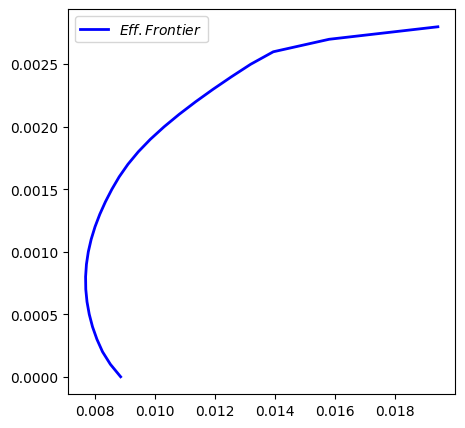

In [14]:
using PyPlot

# Assuming `result` is a previously defined matrix or DataFrame
# where `result[:, :SDp]` represents the x-axis data and `result[:, :ERp]` represents the y-axis data
# Convert data to percentages
x_data = result[:, :SDp]  # Replace `:SDp` with the appropriate column index or name for your x-axis data
y_data = result[:, :ERp]  # Replace `:ERp` with the appropriate column index or name for your y-axis data

# Set the figure size
figure(figsize=(5, 5))  # Width and height in inches

# Plot the efficient frontier
plot(x_data, y_data, color="blue", linewidth=2, label=L"Eff. Frontier")

# Adding legend to the top left
legend(loc="upper left")

# If you want to use LaTeX strings, PyPlot should automatically support them if you have LaTeX installed.
# Otherwise, you can use a string directly for the label, like "Eff. Frontier" if LaTeX is not working.

# Show the plot
show()

In [6]:
# CSV.write("consumption_value_noshort.csv", result, delim = ';')

"consumption_value_noshort.csv"

#### With Short

In [7]:
using Ipopt

ER = returns[:, 1]  # Assuming expected returns are in the first column
C = Matrix(cov[:, 1:end])  # Assuming the first column is labels and the rest are the covariance matrix

n, _ = size(C)

ERp = collect(0.00:0.01:0.8)

result = DataFrame(SDp=NaN,ERp=NaN,x1=NaN,x2=NaN,x3=NaN,x4=NaN,x5=NaN,x6=NaN,x7=NaN,x8=NaN,x9=NaN,x10=NaN)

for k in 1:length(ERp)
    m = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
    @variable(m, x[1:n])
    @NLobjective(m, Min, sum(x[i] * C[i, j] * x[j] for i in 1:n for j in 1:n))
    @NLconstraint(m, sum(ER[i] * x[i] for i in 1:n) == ERp[k])
    @NLconstraint(m, sum(x[i] for i in 1:n) == 1)
    optimize!(m)

    # Create a new row as a tuple
    new_row = (sqrt(objective_value(m)), ERp[k], [round(value(x[i]),digits=4) for i in 1:n]...)
    push!(result, new_row)
end

result

Row,SDp,ERp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00865428,0.0,0.0988,0.1823,-0.0187,-0.0166,0.0297,0.2713,0.1803,-0.0392,0.1115,0.2007
3,0.00856243,0.01,0.0993,0.1833,-0.0142,-0.0122,0.0302,0.2642,0.1797,-0.0356,0.1096,0.1958
4,0.00847454,0.02,0.0997,0.1842,-0.0098,-0.0077,0.0306,0.2571,0.1792,-0.0321,0.1077,0.191
5,0.00839072,0.03,0.1001,0.1852,-0.0053,-0.0032,0.0311,0.25,0.1786,-0.0285,0.1059,0.1862
6,0.00831109,0.04,0.1005,0.1862,-0.0008,0.0012,0.0316,0.2429,0.1781,-0.025,0.104,0.1813
7,0.00823579,0.05,0.101,0.1871,0.0036,0.0057,0.0321,0.2358,0.1775,-0.0214,0.1021,0.1765
8,0.00816493,0.06,0.1014,0.1881,0.0081,0.0101,0.0326,0.2287,0.177,-0.0178,0.1003,0.1716
9,0.00809863,0.07,0.1018,0.1891,0.0126,0.0146,0.033,0.2216,0.1764,-0.0143,0.0984,0.1668


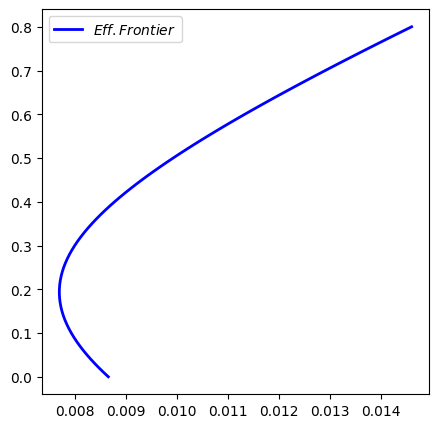

In [8]:
using PyPlot

# Assuming `result` is a previously defined matrix or DataFrame
# where `result[:, :SDp]` represents the x-axis data and `result[:, :ERp]` represents the y-axis data
# Convert data to percentages
x_data = result[:, :SDp]  # Replace `:SDp` with the appropriate column index or name for your x-axis data
y_data = result[:, :ERp]  # Replace `:ERp` with the appropriate column index or name for your y-axis data

# Set the figure size
figure(figsize=(5, 5))  # Width and height in inches

# Plot the efficient frontier
plot(x_data, y_data, color="blue", linewidth=2, label=L"Eff. Frontier")

# Adding legend to the top left
legend(loc="upper left")

# If you want to use LaTeX strings, PyPlot should automatically support them if you have LaTeX installed.
# Otherwise, you can use a string directly for the label, like "Eff. Frontier" if LaTeX is not working.

# Show the plot
show()

In [9]:
# CSV.write("consumption_value_short.csv", result, delim = ';')

"consumption_value_short.csv"

### Growth Stock

In [4]:
returns = DataFrame(CSV.File("consump_growth_returns.csv",header = true))
cov = DataFrame(CSV.File("consump_growth_cov.csv",header = true))

Row,CELH,CLX,EL,ELF,MMYT,ONON,SHAK,SOVO,STRT,WING
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00114398,9.63084e-5,0.000100974,0.000166434,0.000100302,0.000271811,0.000136663,8.98943e-5,0.000113534,0.000145446
2,9.63084e-5,0.000245192,8.45082e-5,0.000109522,3.18854e-5,7.37647e-5,-1.93643e-5,1.48676e-5,-6.57339e-6,6.00782e-5
3,0.000100974,8.45082e-5,0.000664092,0.000161967,7.64131e-5,0.000192323,0.000128942,2.98624e-6,4.20223e-5,-7.56924e-5
4,0.000166434,0.000109522,0.000161967,0.00107744,0.000121579,0.000187936,0.000138602,6.32887e-5,-4.4136e-5,8.02872e-5
5,0.000100302,3.18854e-5,7.64131e-5,0.000121579,0.000430419,9.36182e-5,5.81774e-5,7.64305e-7,2.29986e-5,4.7423e-5
6,0.000271811,7.37647e-5,0.000192323,0.000187936,9.36182e-5,0.00123646,0.00015245,0.000124389,0.000164763,0.000116831
7,0.000136663,-1.93643e-5,0.000128942,0.000138602,5.81774e-5,0.00015245,0.000658731,3.90002e-5,5.41679e-5,0.000118231
8,8.98943e-5,1.48676e-5,2.98624e-6,6.32887e-5,7.64305e-7,0.000124389,3.90002e-5,0.000522541,-6.34435e-7,7.4387e-5
9,0.000113534,-6.57339e-6,4.20223e-5,-4.4136e-5,2.29986e-5,0.000164763,5.41679e-5,-6.34435e-7,0.000716539,1.57135e-5


In [5]:
returns

Row,0
,Float64
1,0.595684
2,0.0792996
3,-0.428982
4,1.10072
5,0.591435
6,0.607195
7,0.665151
8,0.492221
9,0.300914


#### Without Short

In [7]:
using Ipopt

ER = returns[:, 1]  # Assuming expected returns are in the first column
C = Matrix(cov[:, 1:end])  # Assuming the first column is labels and the rest are the covariance matrix

n, _ = size(C)

ERp = collect(0.00:0.01:0.8)

result = DataFrame(SDp=NaN,ERp=NaN,x1=NaN,x2=NaN,x3=NaN,x4=NaN,x5=NaN,x6=NaN,x7=NaN,x8=NaN,x9=NaN,x10=NaN)

for k in 1:length(ERp)
    m = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
    @variable(m, x[1:n] >= 0)
    @NLobjective(m, Min, sum(x[i] * C[i, j] * x[j] for i in 1:n for j in 1:n))
    @NLconstraint(m, sum(ER[i] * x[i] for i in 1:n) == ERp[k])
    @NLconstraint(m, sum(x[i] for i in 1:n) == 1)
    optimize!(m)

    # Create a new row as a tuple
    new_row = (sqrt(objective_value(m)), ERp[k], [round(value(x[i]),digits=4) for i in 1:n]...)
    push!(result, new_row)
end

result

Row,SDp,ERp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0125634,0.0,0.0,0.4712,0.2995,0.0,0.001,0.0,0.0,0.0976,0.1229,0.0079
3,0.0124067,0.01,0.0,0.4661,0.2923,0.0,0.004,0.0,0.0,0.1005,0.1236,0.0135
4,0.0122542,0.02,0.0,0.4607,0.2854,0.0,0.0095,0.0,0.0004,0.1026,0.1237,0.0176
5,0.0121044,0.03,0.0,0.4552,0.2785,0.0,0.0152,0.0,0.0001,0.1049,0.1239,0.0221
6,0.0119589,0.04,0.0,0.4498,0.2716,0.0,0.021,0.0,0.0002,0.1071,0.1241,0.0262
7,0.0118174,0.05,0.0,0.4444,0.2647,0.0,0.0268,0.0,0.0004,0.1092,0.1242,0.0303
8,0.01168,0.06,0.0,0.4392,0.2578,0.0,0.0323,0.0,0.0011,0.1112,0.1243,0.0341
9,0.0115465,0.07,0.0,0.4342,0.2508,0.0,0.0375,0.0,0.0028,0.113,0.1242,0.0375


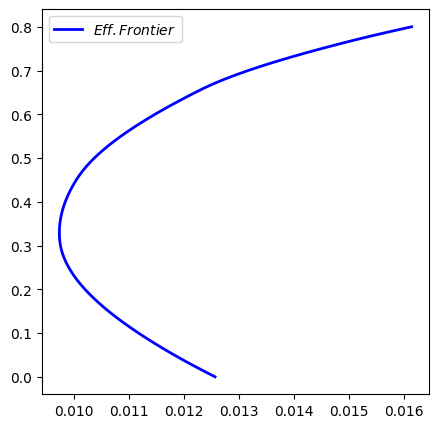

In [13]:
using PyPlot

# Assuming `result` is a previously defined matrix or DataFrame
# where `result[:, :SDp]` represents the x-axis data and `result[:, :ERp]` represents the y-axis data
# Convert data to percentages
x_data = result[:, :SDp]  # Replace `:SDp` with the appropriate column index or name for your x-axis data
y_data = result[:, :ERp]  # Replace `:ERp` with the appropriate column index or name for your y-axis data

# Set the figure size
figure(figsize=(5, 5))  # Width and height in inches

# Plot the efficient frontier
plot(x_data, y_data, color="blue", linewidth=2, label=L"Eff. Frontier")

# Adding legend to the top left
legend(loc="upper left")

# If you want to use LaTeX strings, PyPlot should automatically support them if you have LaTeX installed.
# Otherwise, you can use a string directly for the label, like "Eff. Frontier" if LaTeX is not working.

# Show the plot
show()

In [14]:
# CSV.write("consumption_growth_noshort.csv", result, delim = ';')

"consumption_growth_short.csv"

#### With Short

In [11]:
using Ipopt

ER = returns[:, 1]  # Assuming expected returns are in the first column
C = Matrix(cov[:, 1:end])  # Assuming the first column is labels and the rest are the covariance matrix

n, _ = size(C)

ERp = collect(0.00:0.01:4)

result = DataFrame(SDp=NaN,ERp=NaN,x1=NaN,x2=NaN,x3=NaN,x4=NaN,x5=NaN,x6=NaN,x7=NaN,x8=NaN,x9=NaN,x10=NaN)

for k in 1:length(ERp)
    m = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
    @variable(m, x[1:n])
    @NLobjective(m, Min, sum(x[i] * C[i, j] * x[j] for i in 1:n for j in 1:n))
    @NLconstraint(m, sum(ER[i] * x[i] for i in 1:n) == ERp[k])
    @NLconstraint(m, sum(x[i] for i in 1:n) == 1)
    optimize!(m)

    # Create a new row as a tuple
    new_row = (sqrt(objective_value(m)), ERp[k], [round(value(x[i]),digits=4) for i in 1:n]...)
    push!(result, new_row)
end

result

Row,SDp,ERp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.01166,0.0,-0.0285,0.4666,0.2539,-0.1018,0.084,-0.0479,0.0396,0.1393,0.1269,0.0679
3,0.0115499,0.01,-0.0279,0.462,0.2483,-0.0984,0.0862,-0.047,0.0412,0.1398,0.1267,0.0691
4,0.0114424,0.02,-0.0273,0.4575,0.2427,-0.095,0.0884,-0.0461,0.0428,0.1402,0.1266,0.0702
5,0.0113373,0.03,-0.0267,0.4529,0.2371,-0.0916,0.0906,-0.0451,0.0443,0.1407,0.1264,0.0713
6,0.0112349,0.04,-0.0262,0.4484,0.2316,-0.0882,0.0928,-0.0442,0.0459,0.1411,0.1263,0.0724
7,0.0111351,0.05,-0.0256,0.4438,0.226,-0.0848,0.095,-0.0433,0.0475,0.1416,0.1261,0.0736
8,0.0110381,0.06,-0.025,0.4393,0.2204,-0.0815,0.0973,-0.0423,0.0491,0.1421,0.126,0.0747
9,0.0109439,0.07,-0.0244,0.4347,0.2148,-0.0781,0.0995,-0.0414,0.0507,0.1425,0.1258,0.0758


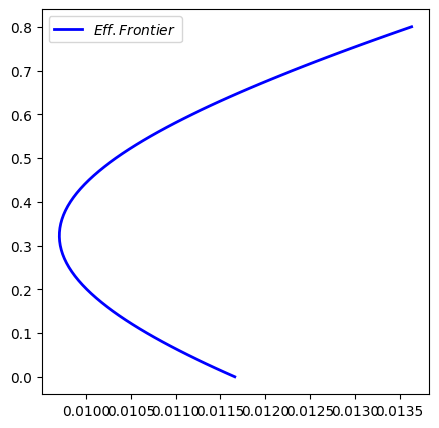

In [16]:
using PyPlot

# Assuming `result` is a previously defined matrix or DataFrame
# where `result[:, :SDp]` represents the x-axis data and `result[:, :ERp]` represents the y-axis data
# Convert data to percentages
x_data = result[:, :SDp]  # Replace `:SDp` with the appropriate column index or name for your x-axis data
y_data = result[:, :ERp]  # Replace `:ERp` with the appropriate column index or name for your y-axis data

# Set the figure size
figure(figsize=(5, 5))  # Width and height in inches

# Plot the efficient frontier
plot(x_data, y_data, color="blue", linewidth=2, label=L"Eff. Frontier")

# Adding legend to the top left
legend(loc="upper left")

# If you want to use LaTeX strings, PyPlot should automatically support them if you have LaTeX installed.
# Otherwise, you can use a string directly for the label, like "Eff. Frontier" if LaTeX is not working.

# Show the plot
show()

In [17]:
# CSV.write("consumption_growth_short.csv", result, delim = ';')

"consumption_growth_short.csv"